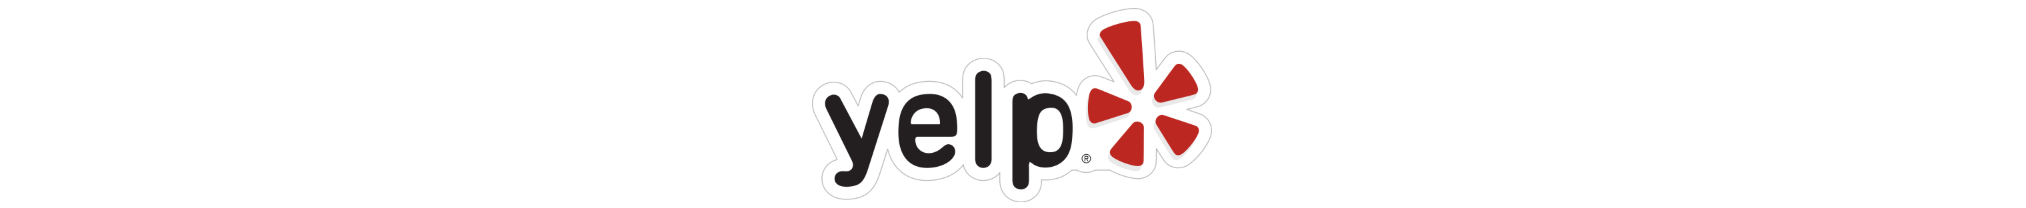

**Group Topic:** Let's Yelp<br/>
**Group Member:** Palash Pandya, Shruti Sharma, Rui Ma

# 1. Introduction

When it comes to online ratings and reviews, everyone benefits. They have the ability to enhance merchant credibility, improve comparison shopping rankings, and raise conversion rates. Reviews can increase customer engagement and also monitor customer service efforts. Ratings and reviews can achieve all of these and more through the power of word of mouth marketing. Yelp is one of the leading websites that has been dedicated to merchants ratings and reviews including restaurants, hair salons and makeup artists, for a long time. The original dataset that we are using is Yelp open dataset, which is 8.65GB, consists of six aspects for the merchants i.e business, reviews, users, check-ins, tips, and photos.

We can use this dataset to analyze the data for a major city in these aspects. After checking the data, we decided on analyzing Las Vegas restaurants. This is a very rich dataset where we have a large number of 'Businesses', 'Reviews' and 'Users', helping us to understand and analyze the user behaviors and to review patterns. There are some other aspects such as hours, availability, locations, reviewing the top reviewers in terms of actual review usages and their review counts, which can also be taken into consideration while analyzing further.

### Questions of Interest 

- **Q1:** What is the most popular type of restaurant in Las Vegas? What is the trend of check-in time for this kind of restaurant?<br/>
Figure out the most popular type of restaurant in Las Vegas. Calculate the number of check-ins over a duration of the time. Visualize the data trend.


- **Q2:** What do we know about users?<br/>
Analyze users' yelping duration, average star of their reviews, types of restaurants they visit, the businesses they checked-in and the frequency they checked in.


- **Q3:** Where are the best restaurants in Las Vegas?<br/>
Which businesses are most popular? How many of these businesses have rating above 3? Where can we find them?


- **Q4:** What did people say about Las Vegas restaurants? <br/>
Analyze reviews using sentiment analysis.

# 2. Data Acquisition and Cleaning Code

## Preparation

In [2]:
%pylab inline
from IPython.display import display
from IPython.display import Image
import json
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud;

Populating the interactive namespace from numpy and matplotlib


## Data Input and Filtering

**Step 2.1** Download JSON file from 'yelp.com/dataset'<br/>
There are 5 JSONs in one file, total 8.65GB, including 6,685,900 reviews, 192,609 businesses, 1,223,094 tips by 1,637,138 users.

**Step 2.2** Seperate one JSON file to 5 JSON files: business, checkin, review, tip, user.

In [2]:
originalFile = open('yelp_dataset','r')
print('Open original file: yelp_dataset.')
currentFile = None
index = 0
while True:
    line = originalFile.readline().strip()
    if line == None:
        if currentFile != None:
            currentFile.close()
        break
    if not line.startswith('{'):
        if currentFile != None:
            currentFile.close()
        fileName = line[0:line.find('.')]
        fileName = fileName.replace('\x00','')
        if fileName == 'photo':
            break
        print('Creating',fileName, 'started from line', str(index))
        currentFile = open(fileName,'wb')
        line = line[line.find('{'):]
    currentFile.write(line.encode())
    currentFile.write('\n'.encode())
    index += 1
print('You got all the files.')

Open original file: yelp_dataset.
Creating business started from line 0
Creating checkin started from line 192609
Creating review started from line 354559
Creating tip started from line 7040459
Creating user started from line 8263553
You got all the files.


**Step 2.3** Convert JSON files to csv files, filter Las Vegas restaurant data.

In [3]:
# encoding: utf-8

# Define the city we plan to research.
CITY = 'Las Vegas'
BUSINESS_SET = set()
USER_SET = set()

# Define headers for 5 csv files.
BUSINESS_TABLE_COLUMNS = ["business_id", "name", "city", "latitude", "longitude", "stars", "review_count", "categories"]
REVIEW_TABLE_COLUMNS = ["review_id", "user_id", "business_id", "stars", "date", "text", "useful", "funny", "cool"]
USER_TABLE_COLUMNS = ["user_id", "name", "review_count", "yelping_since", "useful", "funny", "cool", "fans", "elite", "average_stars"]
CHECKIN_TABLE_COLUMNS = ["business_id", "date"]
TIP_TABLE_COLUMNS = ["text", "date", "compliment_count", "business_id", "user_id"]

def create_csv(tableName, table_row_names):
    print('Creating', tableName, 'csv file.')  
    preload_necessary_data(tableName)
    rawJsonFile = open(tableName, 'r')
    outputFile = open(tableName + '.csv', 'w')
    writer = csv.writer(outputFile)
    writer.writerow(table_row_names)
    index = 0
    while True:
        line = rawJsonFile.readline().strip()
        if line == None or len(line) == 0:
            break
        current_dict = json.loads(line)
        if csv_write_row(tableName, current_dict, table_row_names, writer):
            index += 1
            if (index % 100000 == 0):
                print ("Handling ", index)
    print(str(index), 'rows in', tableName, 'file.')
    outputFile.close()
    rawJsonFile.close()

# Defind a helper function to write rows in csv file.
def csv_write_row(tableName, current_dict, table_row_names, writer):
    canWrite = False
    if tableName == 'business' and current_dict['city'] == CITY:
        categories = current_dict['categories']
        if categories != None and ('food' in categories or 'restaurant' in categories or 'Food' in categories or "Restaurants" in categories):
            canWrite = True
    elif tableName == 'review':
        if current_dict['business_id'] in BUSINESS_SET:
            canWrite = True
    elif tableName == 'user' and current_dict['user_id'] in USER_SET:
        canWrite = True
    elif tableName == 'checkin' and current_dict['business_id'] in BUSINESS_SET:
        canWrite = True
    elif tableName == 'tip' and current_dict['business_id'] in BUSINESS_SET:
        canWrite = True
    if canWrite:
        currentRowInList = list()
        for item in table_row_names:
            tempValue = current_dict[item]
            currentRowInList.append(tempValue)
        writer.writerow(currentRowInList)
    return canWrite

# Check whether to load businessid and userid set.
def preload_necessary_data(tableName):
    business_required = ["review", "checkin", "tip"]
    user_required = ["user"]
    if tableName in business_required and len(BUSINESS_SET) == 0:
        loading_business()
    elif tableName in user_required and len(USER_SET) == 0:
        loading_user()

# Add businessid, userid to corresponding set.
def loading_business():
    fileHandler = open ("business.csv", "r")
    csv_f = csv.reader(fileHandler)
    for row in csv_f:
        business_id = row[0]
        BUSINESS_SET.add(business_id)
    return BUSINESS_SET

def loading_user():
    fileHandler = open ("review.csv", "r")
    csv_f = csv.reader(fileHandler)
    for row in csv_f:
        USER_SET.add(row[1])
    return USER_SET

In [4]:
# Create Las Vegas business csv file.
create_csv('business', BUSINESS_TABLE_COLUMNS)

Creating business csv file.
8286 rows in business file.


In [5]:
# Create Las Vegas business reviews csv file.
create_csv('review', REVIEW_TABLE_COLUMNS)

Creating review csv file.
Handling  100000
Handling  200000
Handling  300000
Handling  400000
Handling  500000
Handling  600000
Handling  700000
Handling  800000
Handling  900000
Handling  1000000
Handling  1100000
Handling  1200000
Handling  1300000
1334902 rows in review file.


In [6]:
# Create Las Vegas business reviews csv file.
create_csv('review', REVIEW_TABLE_COLUMNS)

Creating review csv file.
Handling  100000
Handling  200000
Handling  300000
Handling  400000
Handling  500000
Handling  600000
Handling  700000
Handling  800000
Handling  900000
Handling  1000000
Handling  1100000
Handling  1200000
Handling  1300000
1334902 rows in review file.


In [7]:
# Create Las Vegas business users csv file.
create_csv('user', USER_TABLE_COLUMNS)

Creating user csv file.
Handling  100000
Handling  200000
Handling  300000
Handling  400000
452420 rows in user file.


In [8]:
# Create Las Vegas business checkins csv file.
create_csv('checkin', CHECKIN_TABLE_COLUMNS)

Creating checkin csv file.
8062 rows in checkin file.


# 3.Data Analysis and Visualization

## 3.1 Explore Individual Dataset and Preliminary Analysis

After data inputing and filtering, we got Las Vegas data about restaurants business, users, reviews from 2010 to 2017, total volume is as below:<br/>
- 8286 records of business<br/>
- 8062 records of checkin<br/>
- 452420 records of users<br/>
- 1334902 records or reviews<br/>

In [3]:
# Read csv files.
business = pd.read_csv('business.csv')
checkin = pd.read_csv('checkin.csv')
user = pd.read_csv('user.csv')
review = pd.read_csv('review.csv')

In [10]:
business.head()

business_id                                 name       city  \
0  PZ-LZzSlhSe9utkQYU8pFg           Carluccio's Tivoli Gardens  Las Vegas   
1  tstimHoMcYbkSC4eBA1wEg  Maria's Mexican Restaurant & Bakery  Las Vegas   
2  NBn4hgfGtNz91k3VsDZlmw                         Three Square  Las Vegas   
3  kANF0dbeoW34s2vwh6Umfw                          Dairy Queen  Las Vegas   
4  YK5eFV8uS1bCmp8GeiQ-Qg           All Star Donuts & Kolaches  Las Vegas   

    latitude   longitude  stars  review_count  \
0  36.100016 -115.128528    4.0            40   
1  36.195615 -115.040529    4.5           184   
2  36.236053 -115.096454    5.0            44   
3  36.125031 -115.225620    2.0            33   
4  36.115813 -115.095457    4.0             6   

                                          categories  
0                               Restaurants, Italian  
1  Mexican, Restaurants, Patisserie/Cake Shop, Fo...  
2  Local Services, Food Banks, Community Service/...  
3  Fast Food, Food, Restaurants, Ice Cream & Froz...  
4                                       Food, Donuts

In [11]:
checkin.head()

business_id                                               date
0  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...
1  --q7kSBRb0vWC8lSkXFByA  2010-09-26 23:08:32, 2010-10-03 09:06:15, 2010...
2  -0BxAGlIk5DJAGVkpqBXxg  2010-08-20 19:44:47, 2010-08-26 23:54:03, 2010...
3  -0RkJ_uIduNLWQrphbADRw  2018-08-30 16:32:18, 2018-09-01 19:39:03, 2018...
4  -1m9o3vGRA8IBPNvNqKLmA  2017-10-25 00:48:29, 2017-10-26 02:31:11, 2017...

In [12]:
user.head()

user_id    name  review_count        yelping_since  useful  \
0  bc8C_eETBWL0olvFSJJd0w   David            16  2013-10-04 00:16:10      28   
1  dD0gZpBctWGdWo9WlGuhlA  Angela            17  2014-05-22 15:57:30      30   
2  TEtzbpgA2BFBrC0y0sCbfw   Keane          1122  2006-02-15 18:29:35   13311   
3  KGuqerdeNhxzXZEyBaqqSw   Andre             6  2014-06-07 01:50:09       1   
4  T0gWkTHWRChVUe_Dn1F8nw   Tanya           859  2005-07-20 22:38:17    1630   

   funny   cool  fans                                    elite  average_stars  
0      8     10     0                                      NaN           3.71  
1      4     14     5                                      NaN           4.85  
2  19356  15319   696  2006,2007,2008,2009,2010,2011,2012,2013           4.39  
3      0      1     0                                      NaN           4.33  
4    693   1244    57       2006,2007,2008,2009,2010,2011,2012           4.21

In [13]:
review.head()

review_id                 user_id             business_id  \
0  kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA  8mIrX_LrOnAqWsB5JrOojQ   
1  IByf6mVY0WA838XNSh-5MA  3CJUJILq7CLHk_9OrvpvQg  I4Nr-MVc26qWr08-S3Q1ow   
2  S337tATeouQJdoPYyir29w  2mxBNBeFrgDszqGS5tdEHA  d_L-rfS1vT3JMzgCUGtiow   
3  D_UvaenM25iNd6aehTZ0MA  8NwU4TRsD3S6gIfBqFzDMQ  Sfc8Haz2Yri8Mo1L0E0TsA   
4  qm97yMwREr7BKkexlwLFbg  TTRVdTXKcq-xn6-1IWbwEw  Gyrez6K8f1AyR7dzW9fvAw   

   stars                 date  \
0    4.0  2011-11-30 02:11:15   
1    4.0  2016-01-17 05:26:22   
2    5.0  2016-07-25 03:57:19   
3    5.0  2012-11-06 03:41:43   
4    5.0  2013-12-28 22:28:08   

                                                text  useful  funny  cool  
0  Like walking back in time, every Saturday morn...       0      0     0  
1  The food is always good and the prices are rea...       0      0     0  
2  Pick any meat on the planet and the chef will ...       0      0     0  
3  Great food, great service. Obviously fried chi...       0      0     0  
4  their pettuccine was fresh-made in the morning...       0      0     1

### 3.1.1 What is the most popular type of restaurants in Las Vegas?

In [4]:
# Count the number of each single type. One business can have more than one type.
business_types = business.categories.str.split(',', expand=True)
business = pd.concat((business, business_types), axis=1)
types = business.iloc[:,8:].stack().str.strip().value_counts()
types = pd.DataFrame(types).reset_index()
types.columns = ['Type', 'Count']

In [5]:
# Look through top 50 types
print(list(types[:50]['Type']))

['Restaurants', 'Food', 'Nightlife', 'Fast Food', 'Bars', 'American (Traditional)', 'Mexican', 'Coffee & Tea', 'Sandwiches', 'Pizza', 'American (New)', 'Burgers', 'Breakfast & Brunch', 'Specialty Food', 'Desserts', 'Chinese', 'Italian', 'Shopping', 'Event Planning & Services', 'Seafood', 'Japanese', 'Grocery', 'Convenience Stores', 'Bakeries', 'Ice Cream & Frozen Yogurt', 'Asian Fusion', 'Juice Bars & Smoothies', 'Wine & Spirits', 'Beer', 'Sushi Bars', 'Arts & Entertainment', 'Chicken Wings', 'Cafes', 'Salad', 'Steakhouses', 'Barbeque', 'Sports Bars', 'Caterers', 'Gas Stations', 'Delis', 'Automotive', 'Thai', 'Mediterranean', 'Pubs', 'Hawaiian', 'Food Trucks', 'Korean', 'Lounges', 'Buffets', 'Vegetarian']


**Top 10 type by category:**<br/>
Nightlife, Fast Food, Bars, Coffee & Tea, Sandwiches, Pizza, Burgers, Breakfast & Brunch, Specialty Food, Desserts<br/>

**Top 10 type by region:**<br/>
American (Traditional), Mexican, American (New), Chinese, Italian, Japanese, Thai, Mediterranean, Hawaiian, Korean

In [6]:
types.set_index('Type',inplace=True)

In [7]:
# Filter out business count of top 10 types.
TOP10Cat = types[types.index.isin(['Nightlife', 'Fast Food', 'Bars', 'Coffee & Tea', 'Sandwiches', 'Pizza', 'Burgers', 'Breakfast & Brunch', 'Specialty Food', 'Desserts'])]
TOP10Reg = types[types.index.isin(['American (Traditional)', 'Mexican', 'American (New)', 'Chinese', 'Italian', 'Japanese', 'Thai', 'Mediterranean', 'Hawaiian', 'Korean'])]

In [8]:
TOP10Cat.reset_index(inplace=True)
TOP10Reg.reset_index(inplace=True)

In [63]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Top 10 Cuisine","Top 10 Category"), shared_yaxes=True, horizontal_spacing=0.02)

fig.add_trace(go.Bar(x=TOP10Reg['Type'], y=TOP10Reg['Count'], name='Cuisine'), row=1, col=1)
fig.add_trace(go.Bar(x=TOP10Cat['Type'], y=TOP10Cat['Count'], name='Category'), row=1, col=2)

fig.update_layout(title='Top Las Vegas Restaurant Types', yaxis_title='count')

fig.show()

### 3.1.2 What is the most popular checkin time in Las Vegas?

In [10]:
allCheckinTime = checkin['date'].str.split(',',expand=True).stack().str.strip()

In [11]:
def get_checkinTime_df(checkinTime):
    checkinTime = pd.DataFrame(checkinTime)
    checkinTime = checkinTime[0].str.split(' ', expand=True)
    checkinTime = checkinTime.reset_index().drop(['level_0','level_1'],axis=1)
    checkinTime.columns = ['Date', 'Time']
    date = checkinTime['Date'].str.split('-', expand=True)
    checkinTime['Date'] = pd.to_datetime(checkinTime['Date'])
    checkinTime = pd.concat((checkinTime, date), axis=1)
    checkinTime.columns = ['Date','Time','Year','Month','Day']
    checkinTime['weekDay'] = checkinTime['Date'].dt.day_name()
    return checkinTime

In [12]:
allCheckinTime = get_checkinTime_df(allCheckinTime)

In [31]:
allCheckinTime.head()

Date      Time  Year Month Day weekDay
0 2010-02-08  05:56:47  2010    02  08  Monday
1 2010-02-15  04:47:42  2010    02  15  Monday
2 2010-02-22  03:20:16  2010    02  22  Monday
3 2010-03-12  05:18:41  2010    03  12  Friday
4 2010-03-19  03:42:08  2010    03  19  Friday

In [13]:
allCheckinTime['hour'] = allCheckinTime['Time'].str.slice(stop=2)
allCheckinTimeHour = allCheckinTime.groupby('hour')['Date'].count()

In [14]:
allCheckinTimeHourCopy = allCheckinTimeHour.reset_index()
allCheckinTimeHourCopy.columns = ['hour', 'check-in count']

In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(0,24)), y=allCheckinTimeHourCopy['check-in count'], name='check-in count',
                         line=dict(color='firebrick', width=2)))
fig.update_layout(title='Check-in Time Distribution of Las Vegas Restaurants',
                   xaxis_title='Hour',
                   yaxis_title='check-in count')
fig.show()

**2 am** is the most popular check-in time in Las Vegas, which is a very LV-style feature.

### 3.1.3 What we know about users?

In [16]:
# Data cleaning
user['elite'] = user['elite'].fillna(0)
user.head()

user_id    name  review_count        yelping_since  useful  \
0  bc8C_eETBWL0olvFSJJd0w   David            16  2013-10-04 00:16:10      28   
1  dD0gZpBctWGdWo9WlGuhlA  Angela            17  2014-05-22 15:57:30      30   
2  TEtzbpgA2BFBrC0y0sCbfw   Keane          1122  2006-02-15 18:29:35   13311   
3  KGuqerdeNhxzXZEyBaqqSw   Andre             6  2014-06-07 01:50:09       1   
4  T0gWkTHWRChVUe_Dn1F8nw   Tanya           859  2005-07-20 22:38:17    1630   

   funny   cool  fans                                    elite  average_stars  
0      8     10     0                                        0           3.71  
1      4     14     5                                        0           4.85  
2  19356  15319   696  2006,2007,2008,2009,2010,2011,2012,2013           4.39  
3      0      1     0                                        0           4.33  
4    693   1244    57       2006,2007,2008,2009,2010,2011,2012           4.21

In [17]:
# Create dummy variable 'Elite'
user.loc[:,'Elite'] = 1
user.loc[user['elite'] == 0 , 'Elite'] = 0
user.head()

user_id    name  review_count        yelping_since  useful  \
0  bc8C_eETBWL0olvFSJJd0w   David            16  2013-10-04 00:16:10      28   
1  dD0gZpBctWGdWo9WlGuhlA  Angela            17  2014-05-22 15:57:30      30   
2  TEtzbpgA2BFBrC0y0sCbfw   Keane          1122  2006-02-15 18:29:35   13311   
3  KGuqerdeNhxzXZEyBaqqSw   Andre             6  2014-06-07 01:50:09       1   
4  T0gWkTHWRChVUe_Dn1F8nw   Tanya           859  2005-07-20 22:38:17    1630   

   funny   cool  fans                                    elite  average_stars  \
0      8     10     0                                        0           3.71   
1      4     14     5                                        0           4.85   
2  19356  15319   696  2006,2007,2008,2009,2010,2011,2012,2013           4.39   
3      0      1     0                                        0           4.33   
4    693   1244    57       2006,2007,2008,2009,2010,2011,2012           4.21   

   Elite  
0      0  
1      0  
2      1  
3      0  
4      1

In [21]:
# Create bins for review_count
bins = np.linspace(start=0, stop=50, num=11)
user['Review Count Bin'] = pd.cut(user['review_count'], bins)
user.head()

user_id    name  review_count        yelping_since  useful  \
0  bc8C_eETBWL0olvFSJJd0w   David            16  2013-10-04 00:16:10      28   
1  dD0gZpBctWGdWo9WlGuhlA  Angela            17  2014-05-22 15:57:30      30   
2  TEtzbpgA2BFBrC0y0sCbfw   Keane          1122  2006-02-15 18:29:35   13311   
3  KGuqerdeNhxzXZEyBaqqSw   Andre             6  2014-06-07 01:50:09       1   
4  T0gWkTHWRChVUe_Dn1F8nw   Tanya           859  2005-07-20 22:38:17    1630   

   funny   cool  fans                                    elite  average_stars  \
0      8     10     0                                        0           3.71   
1      4     14     5                                        0           4.85   
2  19356  15319   696  2006,2007,2008,2009,2010,2011,2012,2013           4.39   
3      0      1     0                                        0           4.33   
4    693   1244    57       2006,2007,2008,2009,2010,2011,2012           4.21   

   Elite Review Count Bin  
0      0     (15.0, 20.0]  
1      0     (15.0, 20.0]  
2      1              NaN  
3      0      (5.0, 10.0]  
4      1              NaN

In [18]:
user['Elite'].sum()

38802

In [19]:
user['Elite'].count()

452420

In [22]:
reviewCountBin = pd.DataFrame(user['Review Count Bin'].value_counts())
reviewCountBin.reset_index(inplace=True)

In [23]:
reviewCountBin[7:].sum()

Review Count Bin    26198
dtype: int64

In [24]:
reviewCountBin = reviewCountBin[:7].append({'index':'others','Review Count Bin': 26198},ignore_index=True)
reviewCountBin.columns = ['reviewBin', 'Count']
reviewCountBin

reviewBin   Count
0    (0.0, 5.0]  149922
1   (5.0, 10.0]   71130
2  (10.0, 15.0]   42972
3  (15.0, 20.0]   29358
4  (20.0, 25.0]   21357
5  (25.0, 30.0]   16367
6  (30.0, 35.0]   12881
7        others   26198

In [25]:
user['time'] = pd.to_datetime(user['yelping_since'])
user['dates'] = user['time'].dt.date
user['Year'] = pd.DatetimeIndex(user['dates']).year
user['Month'] = pd.DatetimeIndex(user['dates']).month
user.head()

user_id    name  review_count        yelping_since  useful  \
0  bc8C_eETBWL0olvFSJJd0w   David            16  2013-10-04 00:16:10      28   
1  dD0gZpBctWGdWo9WlGuhlA  Angela            17  2014-05-22 15:57:30      30   
2  TEtzbpgA2BFBrC0y0sCbfw   Keane          1122  2006-02-15 18:29:35   13311   
3  KGuqerdeNhxzXZEyBaqqSw   Andre             6  2014-06-07 01:50:09       1   
4  T0gWkTHWRChVUe_Dn1F8nw   Tanya           859  2005-07-20 22:38:17    1630   

   funny   cool  fans                                    elite  average_stars  \
0      8     10     0                                        0           3.71   
1      4     14     5                                        0           4.85   
2  19356  15319   696  2006,2007,2008,2009,2010,2011,2012,2013           4.39   
3      0      1     0                                        0           4.33   
4    693   1244    57       2006,2007,2008,2009,2010,2011,2012           4.21   

   Elite Review Count Bin                time       dates  Year  Month  
0      0     (15.0, 20.0] 2013-10-04 00:16:10  2013-10-04  2013     10  
1      0     (15.0, 20.0] 2014-05-22 15:57:30  2014-05-22  2014      5  
2      1              NaN 2006-02-15 18:29:35  2006-02-15  2006      2  
3      0      (5.0, 10.0] 2014-06-07 01:50:09  2014-06-07  2014      6  
4      1              NaN 2005-07-20 22:38:17  2005-07-20  2005      7

In [26]:
year_group = user.groupby(by='Year')

In [27]:
Lt1 = []
for name, group in year_group:
    lt = []
    lt.append(name)
    lt.append(len(group))
    Lt1.append(lt)

In [28]:
Time =pd.DataFrame(Lt1)
Time = Time.rename(columns = { 0 : 'Year', 1: 'Users'})
Time

Year  Users
0   2004     35
1   2005    501
2   2006   3076
3   2007   8389
4   2008  15235
5   2009  25938
6   2010  39564
7   2011  56070
8   2012  53493
9   2013  55615
10  2014  58614
11  2015  55527
12  2016  43330
13  2017  23954
14  2018  13079

In [38]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Elite Users Proportion", 'Number of Reviews by Each Users', 'Number of Users 2005-2018','Average Stars by Each Users'), 
    horizontal_spacing=0.02,
    vertical_spacing=0.15,
    specs=[[{"type": "pie"}, {"type": "pie"}],[{"type": "bar"}, {"type": "pie"}]],)
title_text="Yelp Users"

fig.add_trace(go.Pie(labels=['Elite Users','Non-Elite Users'], 
                     values=[38802,452420], hole=.3,
                     title = title_text, name='Elite'), row=1, col=1)
fig.add_trace(go.Pie(labels=['0.0, 5.0 Reviews','5.0, 10.0 Reviews ','10.0, 15.0 Reviews','15.0, 20.0 Reviews', '20.0, 25.0 Reviews','25.0, 30.0 Reviews','30.0, 35.0 Reviews','Others'],
                     values=reviewCountBin['Count'].values, 
                     hole=.3, name='Reviews'), row=1, col=2)
fig.add_trace(go.Bar(x=Time['Year'],
                     y=Time['Users'],
                     name='User Counts'), row=2, col=1)
fig.add_trace(go.Pie(labels=['1.0 - 2.0 Star','2.0 - 3.0 Star ','3.0 - 4.0 Star ','4.0 - 5.0 Star'],
                     values=[77629,55823,114223,204745], name='Stars'), row=2, col=2)


fig.update_layout(title='Users for Las Vegas Restaurants')
fig.update_layout(height=700)

fig.show()

## 3.2 Merge Two Datasets

### 3.2.1 Business Type with Checkin Time

In [39]:
isNightLife = business.categories.str.contains('Nightlife')
isFastFood = business.categories.str.contains('Fast Food')
isCoffeeTea = business.categories.str.contains('Coffee & Tea')
isAmerican = business.categories.str.contains('American')
isMexican = business.categories.str.contains('Mexican')
isChinese = business.categories.str.contains('Chinese')
isItalian = business.categories.str.contains('Italian')
isJapanese = business.categories.str.contains('Japanese')
businessCat = pd.concat((business.iloc[:,:8], isNightLife, isFastFood, isCoffeeTea, isAmerican, isMexican, isChinese, isItalian, isJapanese), axis=1)
businessCat.columns = ['business_id', 'name', 'city', 'latitude', 'longtitude', 'stars', 'review_count', 'categories', 'isNightLife', 'isFastFood', 'isCoffeeTea', 'isAmerican', 'isMexican', 'isChinese', 'isItalian', 'isJapanese']
businessCat.head()

business_id                                 name       city  \
0  PZ-LZzSlhSe9utkQYU8pFg           Carluccio's Tivoli Gardens  Las Vegas   
1  tstimHoMcYbkSC4eBA1wEg  Maria's Mexican Restaurant & Bakery  Las Vegas   
2  NBn4hgfGtNz91k3VsDZlmw                         Three Square  Las Vegas   
3  kANF0dbeoW34s2vwh6Umfw                          Dairy Queen  Las Vegas   
4  YK5eFV8uS1bCmp8GeiQ-Qg           All Star Donuts & Kolaches  Las Vegas   

    latitude  longtitude  stars  review_count  \
0  36.100016 -115.128528    4.0            40   
1  36.195615 -115.040529    4.5           184   
2  36.236053 -115.096454    5.0            44   
3  36.125031 -115.225620    2.0            33   
4  36.115813 -115.095457    4.0             6   

                                          categories  isNightLife  isFastFood  \
0                               Restaurants, Italian        False       False   
1  Mexican, Restaurants, Patisserie/Cake Shop, Fo...         True       False   
2  Local Services, Food Banks, Community Service/...        False       False   
3  Fast Food, Food, Restaurants, Ice Cream & Froz...        False        True   
4                                       Food, Donuts        False       False   

   isCoffeeTea  isAmerican  isMexican  isChinese  isItalian  isJapanese  
0        False       False      False      False       True       False  
1        False       False       True      False      False       False  
2        False       False      False      False      False       False  
3        False       False      False      False      False       False  
4        False       False      False      False      False       False

In [40]:
NightLifeId = businessCat[businessCat['isNightLife'] == True]['business_id']
FastFoodId = businessCat[businessCat['isFastFood'] == True]['business_id']
CoffeeTeaId = businessCat[businessCat['isCoffeeTea']== True]['business_id']
AmericanId = businessCat[businessCat['isAmerican']== True]['business_id']
MexicanId = businessCat[businessCat['isMexican']== True]['business_id']
ChineseId = businessCat[businessCat['isChinese']== True]['business_id']
ItalianId = businessCat[businessCat['isItalian']== True]['business_id']
JapaneseId = businessCat[businessCat['isJapanese']== True]['business_id']
typeDict = {'NightLifeId':NightLifeId, 'FastFoodId':FastFoodId, 'CoffeeTeaId':CoffeeTeaId, 'AmericanId':AmericanId, 'MexicanId':MexicanId, 'ChineseId':ChineseId, 'ItalianId':ItalianId, 'JapaneseId':JapaneseId}          

In [41]:
typeList = ['isNightLife', 'isFastFood', 'isCoffeeTea', 'isAmerican', 'isMexican', 'isChinese', 'isItalian', 'isJapanese']
for istype in typeList:
    listName = istype[2:]+'Id'
    checkin[istype] = [business_id in list(typeDict[listName]) for business_id in list(checkin['business_id'])]

In [53]:
checkin.head()

business_id                                               date  \
0  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...   
1  --q7kSBRb0vWC8lSkXFByA  2010-09-26 23:08:32, 2010-10-03 09:06:15, 2010...   
2  -0BxAGlIk5DJAGVkpqBXxg  2010-08-20 19:44:47, 2010-08-26 23:54:03, 2010...   
3  -0RkJ_uIduNLWQrphbADRw  2018-08-30 16:32:18, 2018-09-01 19:39:03, 2018...   
4  -1m9o3vGRA8IBPNvNqKLmA  2017-10-25 00:48:29, 2017-10-26 02:31:11, 2017...   

   isNightLife  isFastFood  isCoffeeTea  isAmerican  isMexican  isChinese  \
0        False       False        False       False      False      False   
1         True       False        False       False      False      False   
2        False       False         True       False      False      False   
3        False       False         True       False      False      False   
4         True       False        False        True      False      False   

   isItalian  isJapanese  
0      False       False  
1      False       False  
2      False       False  
3      False       False  
4      False       False

In [42]:
checkin_new = pd.merge(checkin, checkin['date'].str.split(',',expand=True).melt().dropna(), left_index=True, right_on='variable')

In [43]:
checkin_new.drop(['date', 'variable'], axis=1)
checkin_new.head()

business_id                                               date  \
0  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...   
1  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...   
2  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...   
3  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...   
4  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...   

   isNightLife  isFastFood  isCoffeeTea  isAmerican  isMexican  isChinese  \
0        False       False        False       False      False      False   
1        False       False        False       False      False      False   
2        False       False        False       False      False      False   
3        False       False        False       False      False      False   
4        False       False        False       False      False      False   

   isItalian  isJapanese  variable                value  
0      False       False         0  2010-02-08 05:56:47  
1      False       False         0  2010-09-26 23:08:32  
2      False       False         0  2010-08-20 19:44:47  
3      False       False         0  2018-08-30 16:32:18  
4      False       False         0  2017-10-25 00:48:29

In [44]:
dateAndTime = checkin_new['value'].str.strip().str.split(' ',expand=True)
checkin_new['Date'] = dateAndTime[0]
checkin_new['Time'] = dateAndTime[1]
checkin_new['Hour'] = checkin_new['Time'].str.slice(stop=2)

In [45]:
hourList = []
for istype in typeList:
    hourList.append(checkin_new[checkin_new[istype]==True].groupby('Hour')['Date'].count())

In [65]:
legendList = ['NightLife', 'FastFood', 'CoffeeTea', 'American', 'Mexican', 'Chinese', 'Italian', 'Japanese']

fig = go.Figure()
for i in range(len(hourList)):
    fig.add_trace(go.Scatter(x=list(range(0,24)), y=hourList[i], name=legendList[i], 
                             line=dict(width=2)))

fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16))
fig.update_layout(title='Check-in Time Distribution of Top Las Vegas Restaurant Types',
                   xaxis_title='Hour',
                   yaxis_title='check-in count')
fig.show()

### 3.2.2 Business Location with Built Date

In [47]:
checkin['builtDate'] = checkin['date'].str.split(',',expand=True)[0]
checkin.head()

business_id                                               date  \
0  --9e1ONYQuAa-CB_Rrw7Tw  2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...   
1  --q7kSBRb0vWC8lSkXFByA  2010-09-26 23:08:32, 2010-10-03 09:06:15, 2010...   
2  -0BxAGlIk5DJAGVkpqBXxg  2010-08-20 19:44:47, 2010-08-26 23:54:03, 2010...   
3  -0RkJ_uIduNLWQrphbADRw  2018-08-30 16:32:18, 2018-09-01 19:39:03, 2018...   
4  -1m9o3vGRA8IBPNvNqKLmA  2017-10-25 00:48:29, 2017-10-26 02:31:11, 2017...   

   isNightLife  isFastFood  isCoffeeTea  isAmerican  isMexican  isChinese  \
0        False       False        False       False      False      False   
1         True       False        False       False      False      False   
2        False       False         True       False      False      False   
3        False       False         True       False      False      False   
4         True       False        False        True      False      False   

   isItalian  isJapanese            builtDate  
0      False       False  2010-02-08 05:56:47  
1      False       False  2010-09-26 23:08:32  
2      False       False  2010-08-20 19:44:47  
3      False       False  2018-08-30 16:32:18  
4      False       False  2017-10-25 00:48:29

In [48]:
builtDate = checkin.loc[:,['business_id','builtDate']]
businessWithBuiltDate = businessCat.merge(builtDate, left_on = 'business_id', right_on = 'business_id')

In [49]:
businessWithBuiltDate['builtYear'] = businessWithBuiltDate['builtDate'].str[:4]
businessWithBuiltDate.head()

business_id                                 name       city  \
0  PZ-LZzSlhSe9utkQYU8pFg           Carluccio's Tivoli Gardens  Las Vegas   
1  tstimHoMcYbkSC4eBA1wEg  Maria's Mexican Restaurant & Bakery  Las Vegas   
2  NBn4hgfGtNz91k3VsDZlmw                         Three Square  Las Vegas   
3  kANF0dbeoW34s2vwh6Umfw                          Dairy Queen  Las Vegas   
4  YK5eFV8uS1bCmp8GeiQ-Qg           All Star Donuts & Kolaches  Las Vegas   

    latitude  longtitude  stars  review_count  \
0  36.100016 -115.128528    4.0            40   
1  36.195615 -115.040529    4.5           184   
2  36.236053 -115.096454    5.0            44   
3  36.125031 -115.225620    2.0            33   
4  36.115813 -115.095457    4.0             6   

                                          categories  isNightLife  isFastFood  \
0                               Restaurants, Italian        False       False   
1  Mexican, Restaurants, Patisserie/Cake Shop, Fo...         True       False   
2  Local Services, Food Banks, Community Service/...        False       False   
3  Fast Food, Food, Restaurants, Ice Cream & Froz...        False        True   
4                                       Food, Donuts        False       False   

   isCoffeeTea  isAmerican  isMexican  isChinese  isItalian  isJapanese  \
0        False       False      False      False       True       False   
1        False       False       True      False      False       False   
2        False       False      False      False      False       False   
3        False       False      False      False      False       False   
4        False       False      False      False      False       False   

             builtDate builtYear  
0  2010-03-05 03:54:37      2010  
1  2010-06-26 20:40:58      2010  
2  2010-02-17 20:59:43      2010  
3  2010-07-05 00:23:21      2010  
4  2011-11-14 23:04:02      2011

In [51]:
# Mapbox token
mapbox_access_token = 'pk.eyJ1IjoicnVpbWFheCIsImEiOiJjazJucDFrM3YwMnZyM2ltd3p0c2dpM2N6In0.52B-BmR2dG3Bh8Ui_OfYUQ'

yearList = ['2011','2012','2013','2014','2015','2016','2017','2018']
yearListCopy = [2011,2012,2013,2014,2015,2016,2017,2018]

businessWithBuiltDate['builtYearCopy'] = businessWithBuiltDate['builtYear'].astype(float)

data = [go.Scattermapbox(
               lat=[36.1],
               lon=[-115.2],
               mode='markers',
               marker=dict(size=4, color='red', opacity=0.5)
            )
        ]

frames = [dict(data = [dict(type='scattermapbox',
                        lat=businessWithBuiltDate[businessWithBuiltDate['builtYearCopy'] <= year]['latitude'],
                        lon=businessWithBuiltDate[businessWithBuiltDate['builtYearCopy'] <= year]['longtitude'])],
               traces = [0],
               name = year       
              )for year in yearListCopy]  

layout = go.Layout(width=800,
    autosize=True,
    hovermode='closest',
    mapbox=dict(accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(lat=36.1,
                            lon=-115.2),
                pitch=0,
                zoom=8,
                style='light'
                )
            )

sliders = [dict(steps= [dict(method= 'animate',
                           args= [[year],
                                  dict(mode= 'immediate',
                                  frame = dict( duration=100, redraw= True ),
                                           transition=dict( duration= 0)
                                          )
                                    ],
                             ) for year in yearList], 
                transition= dict(duration= 0 ),
                x=0,  
                y=0, 
                currentvalue=dict(font=dict(size=12), 
                                  prefix='Point: ', 
                                  visible=True, 
                                  xanchor= 'center'),  
                len=1.0)
           ]

layout.update(updatemenus=[dict(type='buttons', showactive=False,
                                y=0,
                                x=1.05,
                                xanchor='right',
                                yanchor='top',
                                pad=dict(t=0, r=10),
                                buttons=[dict(label='Play',
                                              method='animate',
                                              args=[None, 
                                                    dict(frame=dict(duration=100, 
                                                                    redraw=True),
                                                         transition=dict(duration=0),
                                                         fromcurrent=True,
                                                         mode='immediate'
                                                        )
                                                   ]
                                             )
                                        ]
                               )
                          ],
              title = 'Yelp Restaurants In Las Vegas',
              sliders=sliders);

fig=go.Figure(data=data, layout=layout, frames=frames)
fig.show()

### 3.2.3 Business with Check-in Times

In [52]:
checkin_new['year'] = checkin_new['Date'].str[:4]

In [53]:
checkin_location = businessCat.merge(checkin_new[['business_id', 'year']], left_on = 'business_id', right_on = 'business_id')
checkin_location.head()

business_id                        name       city   latitude  \
0  PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  Las Vegas  36.100016   
1  PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  Las Vegas  36.100016   
2  PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  Las Vegas  36.100016   
3  PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  Las Vegas  36.100016   
4  PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  Las Vegas  36.100016   

   longtitude  stars  review_count            categories  isNightLife  \
0 -115.128528    4.0            40  Restaurants, Italian        False   
1 -115.128528    4.0            40  Restaurants, Italian        False   
2 -115.128528    4.0            40  Restaurants, Italian        False   
3 -115.128528    4.0            40  Restaurants, Italian        False   
4 -115.128528    4.0            40  Restaurants, Italian        False   

   isFastFood  isCoffeeTea  isAmerican  isMexican  isChinese  isItalian  \
0       False        False       False      False      False       True   
1       False        False       False      False      False       True   
2       False        False       False      False      False       True   
3       False        False       False      False      False       True   
4       False        False       False      False      False       True   

   isJapanese  year  
0       False  2018  
1       False  2013  
2       False  2015  
3       False  2015  
4       False  2015

In [55]:
restaurant_checkin = checkin_location.groupby(['business_id','name','year']).count()['city']
restaurant_checkin = restaurant_checkin.reset_index()
restaurant_checkin.columns = ['business_id', 'name', 'check-in year', 'check-in times']
restaurant_checkin
yearGroup = restaurant_checkin.groupby('check-in year')

In [56]:
def MostVistRestaurant(year):
    year_df = yearGroup.get_group(year).sort_values(by='check-in times',ascending=False)
    year_top10 = year_df[:10].merge(businessWithBuiltDate, left_on = 'business_id', right_on = 'business_id')
    year_top10 = year_top10[['business_id','name_x','check-in times','latitude','longtitude','stars','categories']]
    simple_top10 = year_top10[['name_x','check-in times']]
    simple_top10.columns=[str(year)+'Top10', str(year)+'times']
    return simple_top10

all_top10 = MostVistRestaurant('2011')
for year in yearList[1:]:
    all_top10 = pd.concat((all_top10, MostVistRestaurant(year)), axis=1)

all_top10['Rank']=list(range(1,11))
all_top10.set_index('Rank')

2011Top10  2011times  \
Rank                                            
1                      Smashburger       1536   
2                   The Neapolitan       1530   
3              Woo Chun Korean BBQ       1526   
4                        Starbucks       1524   
5                 Ichi Ramen House       1520   
6                     Fresh Buffet       1520   
7                The Butcher Block       1516   
8     The Perfect Scoop & Boba Tea       1516   
9         Sin City Thai Restaurant       1514   
10                          Argana       1513   

                                    2012Top10  2012times  \
Rank                                                       
1                             In-N-Out Burger        825   
2                               The Rice Shop        824   
3                                 Smashburger        823   
4                      Merkato Ethiopian Cafe        820   
5                               K Jun Chicken        819   
6     Taiga Modern Japanese & Thai Restaurant        817   
7                                  Toddy Shop        816   
8                               Medley Buffet        814   
9                                 Pho Kinh Do        813   
10                                Flame Kabob        813   

                              2013Top10  2013times  \
Rank                                                 
1              Sin City Thai Restaurant        728   
2                      La Costa Del Sol        711   
3                          8 Noodle Bar        711   
4                       99 Ranch Market        709   
5                             Starbucks        707   
6                     The Butcher Block        706   
7                          Michael Mina        705   
8                           Dolphin Bar        705   
9                         Panda Express        705   
10    Vegas Uncork'd: The Grand Tasting        704   

                              2014Top10  2014times  \
Rank                                                 
1                      Rooster Boy Cafe        650   
2            The Coffee Bean & Tea Leaf        645   
3            Bavette's Steakhouse & Bar        642   
4                        The Neapolitan        639   
5                       In-N-Out Burger        637   
6                                Argana        635   
7                Merkato Ethiopian Cafe        634   
8     Vegas Uncork'd: The Grand Tasting        634   
9                   Woo Chun Korean BBQ        633   
10                         Fresh Buffet        632   

                           2015Top10  2015times  \
Rank                                              
1                   Ichi Ramen House        624   
2     Red Ginseng Narita Sushi & BBQ        617   
3                        AL's Donuts        616   
4                        Smashburger        615   
5                  La Tapatia Market        615   
6       The Perfect Scoop & Boba Tea        614   
7                          Starbucks        614   
8                       Michael Mina        613   
9             Double Play Sports Bar        612   
10                 The Butcher Block        612   

                           2016Top10  2016times  \
Rank                                              
1                  La Tapatia Market        537   
2               Delmonico Steakhouse        534   
3       The Perfect Scoop & Boba Tea        534   
4     Red Ginseng Narita Sushi & BBQ        534   
5                   Rooster Boy Cafe        533   
6         Bavette's Steakhouse & Bar        531   
7           Sin City Thai Restaurant        529   
8                  The Butcher Block        529   
9                          Starbucks        529   
10        The Coffee Bean & Tea Leaf        529   

                              2017Top10  2017times  \
Rank                                                 
1                  Delmonico Steakhouse        537   
2                Double Play 

### 3.2.4 Business Type with Location

In [57]:
# Mapbox token
mapbox_access_token = 'pk.eyJ1IjoicnVpbWFheCIsImEiOiJjazJucDFrM3YwMnZyM2ltd3p0c2dpM2N6In0.52B-BmR2dG3Bh8Ui_OfYUQ'

restaurant_map_data = [go.Scattermapbox(
        lon = businessWithBuiltDate['longtitude'],
        lat = businessWithBuiltDate['latitude'],
        text = businessWithBuiltDate['name'],
        hoverinfo='text',
        mode = 'markers',
        marker = dict(
                    color = 'black',
                    symbol = 'circle',
                    size = 4,
                    opacity = .5
                ),
        name = 'general restaurant'
),
                       go.Scattermapbox(
        lon = businessWithBuiltDate[businessWithBuiltDate['isNightLife']==True]['longtitude'],
        lat = businessWithBuiltDate[businessWithBuiltDate['isNightLife']==True]['latitude'],
        text = businessWithBuiltDate[businessWithBuiltDate['isNightLife']==True]['name'] + '<br>' + 'NightLife',
        hoverinfo='text',
        mode = 'markers',
        marker = dict(
                    color = 'red',
                    symbol = 'circle',
                    size = 4,
                    opacity = .5
                ),
        name = 'NightLife')]                    

restaurant_map_layout = go.Layout(
        title = 'Yelp Restaurants In Las Vegas',
        mapbox=go.layout.Mapbox(
            accesstoken=mapbox_access_token,
            #zoom=0
        )
    )

restaurant_map = go.Figure(data=restaurant_map_data, layout=restaurant_map_layout)
restaurant_map.update_layout(mapbox_center_lat=36.1, mapbox_center_lon=-115.2, mapbox_zoom = 9)
restaurant_map.show()

### 3.2.4 Score with Business Location

In [58]:
star_fig = go.Figure(
    go.Densitymapbox(lat=businessWithBuiltDate['latitude'], 
                     lon=businessWithBuiltDate['longtitude'],
                     z=businessWithBuiltDate['stars'], radius=4))
star_fig.update_layout(mapbox_style="stamen-terrain")
star_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
star_fig.update_layout(mapbox_center_lat=36.1, mapbox_center_lon=-115.2, mapbox_zoom = 10)
star_fig.show()

### 3.2.5 Score with Business Type

In [59]:
allTypeStar = businessWithBuiltDate[businessWithBuiltDate['isNightLife']==True]['stars'].value_counts().sort_index()
for istype in typeList:
    newSeries = businessWithBuiltDate[businessWithBuiltDate[istype]==True]['stars'].value_counts().sort_index()
    allTypeStar = pd.concat((allTypeStar, newSeries),axis=1)

allTypeStar.columns = [['s1','s2','s3','s4','s5','s6','s7','s8','s9']]
allTypeStar = allTypeStar.drop(['s1'],axis=1)
allTypeStar.columns = typeList
allTypeStar = allTypeStar.fillna(0)
allTypeStar

isNightLife  isFastFood  isCoffeeTea  isAmerican  isMexican  isChinese  \
1.0            1          12            9           1          1          2   
1.5            4          72           25           9         11          7   
2.0           17         194           69          49         33         22   
2.5           68         214          102         165         93         42   
3.0          150         205          116         261        151        111   
3.5          296         139          131         355        197        142   
4.0          329          92          156         379        181         94   
4.5          135          42          123         169        119         41   
5.0           23           8           27          30         32          4   

     isItalian  isJapanese  
1.0          1         0.0  
1.5          3         1.0  
2.0         23         3.0  
2.5         34        11.0  
3.0         60        41.0  
3.5        126        84.0  
4.0        134       140.0  
4.5         52        86.0  
5.0          8        10.0

In [60]:
# Data
r = [0,1,2,3,4,5,6,7]
df = allTypeStar.T
df.fillna(0)

# From raw value to percentage
totals = [s1+s2+s3+s4+s5+s6+s7+s8+s9 for s1,s2,s3,s4,s5,s6,s7,s8,s9 in zip(df[1.0], df[1.5], df[2.0], df[2.5], df[3.0], df[3.5], df[4.0], df[4.5], df[5])]
s1Bars = [i / j * 100 for i,j in zip(df[1.0], totals)]
s2Bars = [i / j * 100 for i,j in zip(df[1.5], totals)]
s3Bars = [i / j * 100 for i,j in zip(df[2.0], totals)]
s4Bars = [i / j * 100 for i,j in zip(df[2.5], totals)]
s5Bars = [i / j * 100 for i,j in zip(df[3.0], totals)]
s6Bars = [i / j * 100 for i,j in zip(df[3.5], totals)]
s7Bars = [i / j * 100 for i,j in zip(df[4.0], totals)]
s8Bars = [i / j * 100 for i,j in zip(df[4.5], totals)]
s9Bars = [i / j * 100 for i,j in zip(df[5.0], totals)]

In [61]:
names = typeList
fig = go.Figure(go.Bar(x=names, y=s1Bars, name='1.0'))
fig.add_trace(go.Bar(x=names, y=s2Bars, name='1.5'))
fig.add_trace(go.Bar(x=names, y=s3Bars, name='2.0'))
fig.add_trace(go.Bar(x=names, y=s4Bars, name='2.5'))
fig.add_trace(go.Bar(x=names, y=s5Bars, name='3.0'))
fig.add_trace(go.Bar(x=names, y=s6Bars, name='3.5'))
fig.add_trace(go.Bar(x=names, y=s7Bars, name='4.0'))
fig.add_trace(go.Bar(x=names, y=s8Bars, name='4.5'))
fig.add_trace(go.Bar(x=names, y=s9Bars, name='5.0'))

fig.update_layout(barmode='stack', xaxis={'categoryorder':'array', 'categoryarray':['d','a','c','b']})

fig.update_layout(title='Score Distribution of Top Las Vegas Restaurant Types',
                   xaxis_title='Type',
                   yaxis_title='Percentage')
fig.show()

## 3.3 Sentimental Analysis

In [ ]:
rev = pd.read_csv("review.csv")
ser = pd.read_csv("business.csv")

# Creating 2 empty lists to hold buiness Ids for Italian & Mexican restaurants respectively.

italian = []
mexican = []

# fetching the business Ids for restaurants serving Italian cuisine & Mexican cuisine. 

for i in range(len(ser)):
    if 'Italian' in ser['categories'][i]:
        italian.append(ser['business_id'][i])
        
    if 'Mexican' in ser['categories'][i]:
        mexican.append(ser['business_id'][i])

In [ ]:
# Creating 2 empty lists to hold reviews for Italian & Mexican restaurants respectively.

ls_italian = []
ls_mexican = []

# for business Ids fetched above, fetching their respective reviews

for i in range(len(rev)):
    
    if rev['business_id'][i] in italian:
        if type(rev['text'][i])==str:
            ls_italian.append(rev['text'][i])
    else:
        continue        
        
    if rev['business_id'][i] in mexican:
        if type(rev['text'][i])==str:
            ls_mexican.append(rev['text'][i])
    else:
        continue

In [ ]:
# Total number of reviews for Italian & Mexican restaurants

print("No. of Italian restaurants whose reviews are available : ", len(ls_italian))
print("No. of Mexican restaurants whose reviews are available : ", len(ls_mexican))

In [ ]:
# Tokenizing reviews of Italian restaurants for NLP 

tkn_italian = []

for i in range(len(ls_italian)):
    
    # processing each review
    text_it = ls_italian[i]
    
    # converting each review sentence to tokens
    tokens_it = [w for w in word_tokenize(text_it.lower()) if w.isalpha()]
    
    # removing the stopwords from the tokens_it
    no_stops_it = [t for t in tokens_it if t not in stopwords.words('english')]
    
    # Stemming each word in no_stops_it
    ps_it = PorterStemmer()
    stem_words_it = [ps_it.stem(word) for word in no_stops_it]
    
    # Lemmatizing each word in stemmed words
    word_lemmatizer_it = WordNetLemmatizer()
    lemmatized_it = [word_lemmatizer_it.lemmatize(t) for t in stem_words_it]
    
    # creating a list of all the words in the review
    tkn_italian.append(lemmatized_it)

In [ ]:
# Tokenizing reviews of Mexican restaurants for NLP 

tkn_mexican = []

for i in range(len(ls_mexican)):
    
    # processing each review
    text_mx = ls_mexican[i]
    
    # converting each review sentence to tokens
    tokens_mx = [w for w in word_tokenize(text_mx.lower()) if w.isalpha()]
    
    # removing the stopwords from the tokens_it
    no_stops_mx = [t for t in tokens_mx if t not in stopwords.words('english')]
    
    # Stemming each word in no_stops_it
    ps_mx = PorterStemmer()
    stem_words_mx = [ps_mx.stem(word) for word in no_stops_mx]
    
    # Lemmatizing each word in stemmed words
    word_lemmatizer_mx = WordNetLemmatizer()
    lemmatized_mx = [word_lemmatizer_mx.lemmatize(t) for t in stem_words_mx]
    
    # creating a list of all the words in the review
    tkn_mexican.append(lemmatized_mx)

In [ ]:
# converting the sublists in tkn_italian and tkn_mexican as flat lists

flat_list_italian = [item for sublist in tkn_italian for item in sublist]
flat_list_mexican = [item for sublist in tkn_mexican for item in sublist]

In [ ]:
# calculating the frequency of words in italian reviews and mexican reviews

from nltk.text import Text

fd_italian = FreqDist(Text(flat_list_italian))
fd_mexican = FreqDist(Text(flat_list_mexican))

In [ ]:
# Most frequent 10 words in Italian reviews
fd_italian.most_common(10)

In [ ]:
# Visualize frequency of most common words in italian reviews

plt.figure(figsize=(12,4))
fd_italian.plot(20, title = "Frequent 20 words in Italian restaurants review")

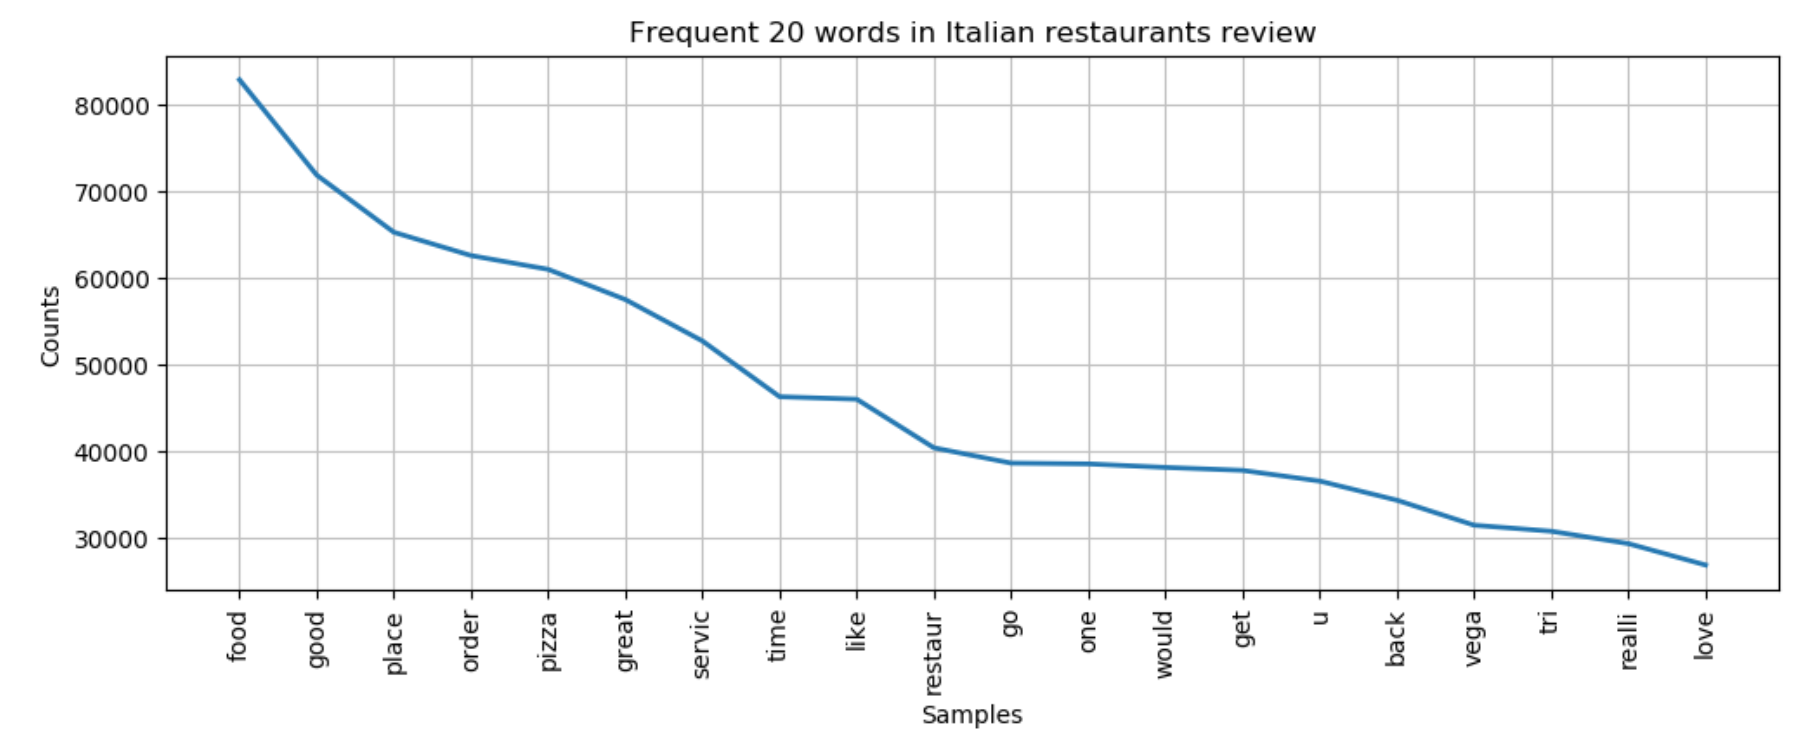

In [5]:
display(Image('S1.png'))

In [ ]:
# Most frequent 10 words in Mexican reviews

fd_mexican.most_common(10)

In [ ]:
# Visualize word cloud of most common words in Mexican reviews

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color='black', mask = mask).generate(' '.join(flat_list2))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title("Cloud of Frequent 20 words in Mexican restaurants review");

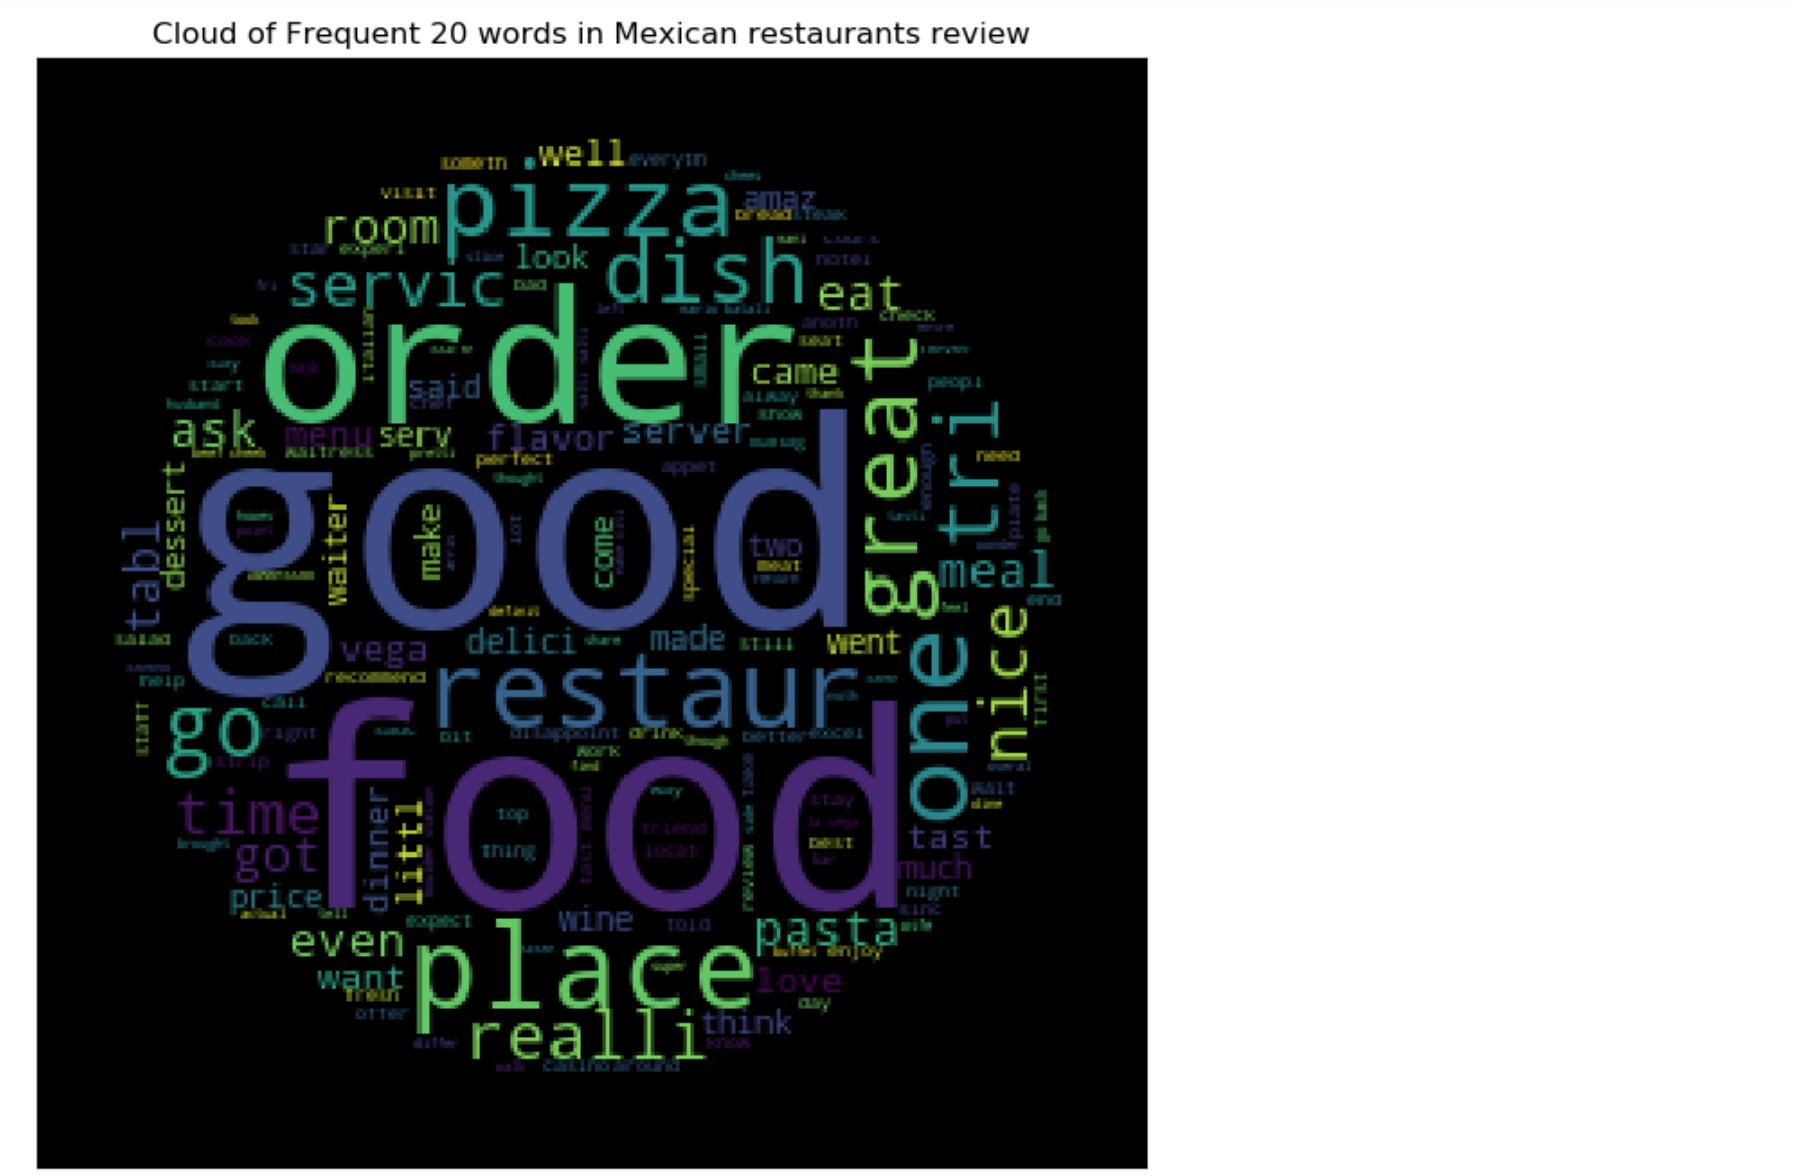

In [4]:
display(Image('S2.png'))

In [ ]:
# from the above bag of words for various cuisine types, getting the positive 
# and negative words used by the reviewers to express their sentiment

positive = ['good', 'great', 'nice', 'best', 'love', 'happy', 'recommend', 'delight', 'delicious', 'yummy', 'super', 'excellent', 'awesome', 'enjoy']
negative = ['bad', 'worse', 'worst', 'hate', 'unhappy', 'problem', 'rude', 'horrible', 'disappoint', 'upset']

In [ ]:
# Checking out the frequency of positive sentiments and negative sentiments for 
# Mexican restaurants in Las Vegas

p2 = 0
n2 = 0

for i in range(len(flat_list_mexican)):
    if flat_list_mexican[i] in positive:
        p2 = p2+1
        
    elif flat_list_mexican[i] in negative:
        n2 = n2+1

p2 = (p2*100)/len(flat_list_mexican)
n2 = (n2*100)/len(flat_list_mexican)

In [ ]:
# data to plot
n_groups = 2
it = (p1,n1)
mx = (p2,n2)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, it, bar_width,alpha=opacity,color='b',label='Italian')

rects2 = plt.bar(index + bar_width, mx, bar_width,alpha=opacity,color='g',label='Mexican')

plt.xlabel('Popularity of the cuisine type')
plt.ylabel('Avg Experience Scores on basis ofUsers reviews')
plt.title('Reviews interpretation of Italian & Mexican restaurants in Las Vegas')
plt.xticks(index + bar_width, ('Good_reviews', 'Bad_reviews'))
plt.legend()

plt.show()

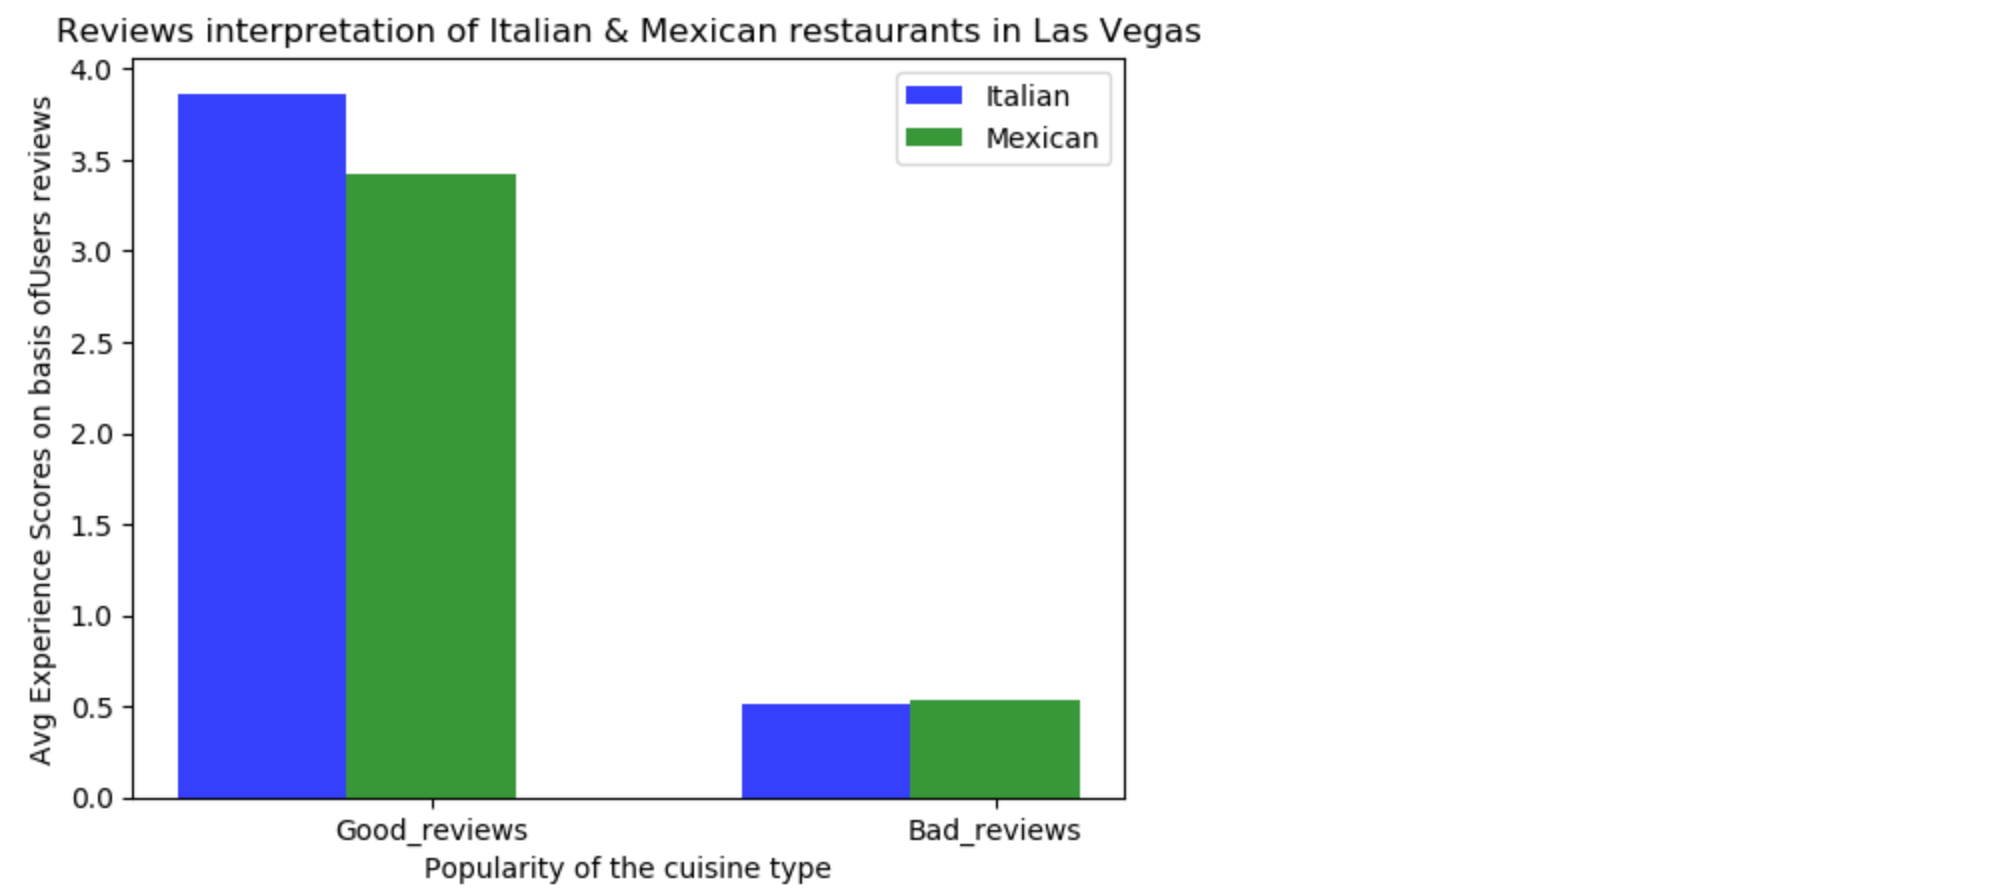

In [3]:
display(Image('S3.png'))

# #END and Thank You : )